# 8-1 프로젝트 : 뉴스기사 요약
### 프로젝트1 : 추상적 요약 (seq2seq)
### 프로젝트2 : 추출적 요약

# 프로젝트 1 : 추상적 요약
## 0. 라이브러리

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


## 1. 데이터 수집
- 데이터 : [news_summary_more.csv](https://github.com/sunnysai12345/News_Summary)

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### 1.1 데이터 확인

In [3]:
print('전체 샘플수 :', (len(data)))
data.sample(10)

전체 샘플수 : 98401


,headlines,text
2639,Tata Motors-owned Jaguar Land Rover to slash 4...,Tata Motors-owned Jaguar Land Rover plans to s...
5675,Kohli continues to be my favourite: Sir Vivian...,Former Windies captain Sir Vivian Richards on ...
94185,Kim denies rumours of going bankrupt post spli...,Actress Kim Sharma denied rumours that had eme...
31704,German court bars Muslim teacher from wearing ...,A German court on Wednesday ruled against a Mu...
65220,HC stops Centre's plan to remove troops from D...,The Calcutta High Court on Tuesday temporarily...
93567,PV Sindhu slips to 5th rank after 1st round ex...,Shuttler PV Sindhu slipped three places to fif...
96192,Afghan national booked after heroin found in r...,A 19-year-old Afghan national was booked on Tu...
23459,Startup raises $11 mn led by Google to test ap...,US-based artificial intelligence (AI) startup ...
95964,Asteroid with similar orbit as Jupiter orbits ...,Canada-based scientists have confirmed the fir...
70875,500 kg of ganja worth Ã¢ÂÂ¹2 crore seized in ...,Around 500 kg of ganja was seized from a tract...


### 1.2 데이터 변환
- 'text'-> 'Text'
- 'headlines' -> 'Summary'

In [4]:
data = data.rename(columns={'headlines': 'Summary', 'text': 'Text'})
data = data.reindex(columns=['Text', 'Summary'])
data.head()

,Text,Summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


## 2. 데이터 전처리

### 2.1-1 중복 데이터 확인

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


### 2.1-2 Text 중복 데이터 제거
- drop_duplicates: Text의 중복 데이터를 제거
- Summary의 경우 같은 요약이 있을 수 있음

In [6]:
data.drop_duplicates(subset = ['Text'], inplace=True) # inplace=True : DataFrame 타입 값을 return 하지 않고 data 내부를 직접 변경
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2.1-3 결측치 확인
- drop_duplicates로 사라지지 않은 Null 확인

In [7]:
# 결측치 확인
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


## 2.2 텍스트 정리
### 2.2-1 정규화 사전
- [정규화 사전](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
  - ex): "it'll" = "it will"
  - ex): "mustn't" = "must not"

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 2.2-2 불용어 리스트
- NLTK 제공 리스트
  - ex): "the"

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from nltk.corpus import stopwords
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 2.2-3 데이터 전처리 함수
- 약어 정규화
  - 정규화 사전 이용
- 불용어 제거
  - remove_stopwords를 인자로 받아 Text에만 제거
- 소문자화
- html태그 제거
- 공백 제거
- ...

In [11]:
from bs4 import BeautifulSoup 
import re
# 데이터 전처리 함수
# NLTK 제거 파트가 Summary에는 남기고 Text 전처리시에만 호출
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

### 2.2-4 Text 데이터 전처리
- preprocess_sentence(sentence)
  - remove_stopwords : 불용어 제거

In [12]:
clean_text = []
for sentence in data["Text"]:
    processed_sentence = preprocess_sentence(sentence)
    clean_text.append(processed_sentence)
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

### 2.2-5 Summary 데이터 전처리
- preprocess_sentence(sentence,False)
  - 불용어 제거 X

In [13]:
clean_summary = []

for sentence in data["Summary"]:
    processed_sentence = preprocess_sentence(sentence,False)
    clean_summary.append(processed_sentence)

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


### 2.2-6 empty 데이터 확인
- 사라진 데이터를 확인
- 사라진 데이터를 Null로 변경
- Null 제거

In [14]:
import numpy as np
# 빈(empty) 샘플 확인
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# Null 값 확인
print(data.isnull().sum())

# Null값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

Text       0
Summary    0
dtype: int64
전체 샘플수 : 98360


## 2.3 샘플의 최대 길이 지정
### 2.3.1 샘플의 길이 분포 확인
- 최소길이, 최대길이, 평균길이, 표준편차
- boxplot, histgram

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트의 표준 편차 : 3.7993861876499637
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534
요약의 표준 편차 : 1.3900944321771693


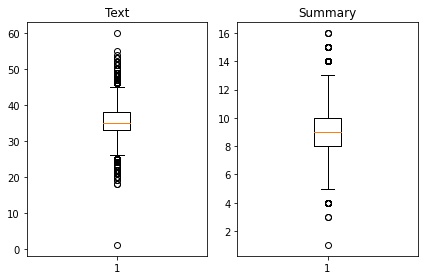

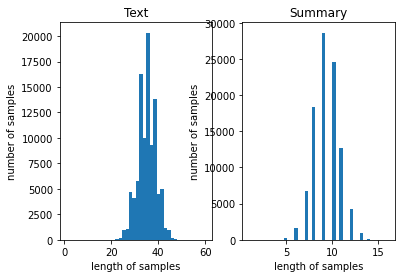

In [15]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 표준 편차 : {}'.format(np.std(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))
print('요약의 표준 편차 : {}'.format(np.std(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(1,2,2)
plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 2.3.2 최대 길이 지정
- text_max_len, summary_max_len
- 평균 + 1.5*표준편차

In [16]:
text_max_len = int(np.mean(text_len) + 1.5 * np.std(text_len))
summary_max_len = int(np.mean(summary_len) + 1.5 * np.std(summary_len))

print(text_max_len, summary_max_len)

40 11


### 2.3.3 최대 길이 내에 포함되는 데이터 비율
- text: 0.9238
- summary: 0.9449

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


### 2.3.4 포함되지 않는 데이터 제외
- 최대 길이 (text_max_len, summary_max_len)보다 짧은 데이터만 선택
- 98360->85843

In [18]:
data = data[
    data['Text'].apply(lambda x: len(x.split()) <= text_max_len) &
    data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)
]


print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


## 2.4 토큰
- seq2seq 훈련을 위해 토큰 추가
- 디코더(Summary)의 입력과 레이블에 시작토큰, 종료토큰 추가
### 2.4.1 토큰 추가
- decoder_input
  - 시작토큰: 'sostoken'
- decoder_target
  - 종료토큰: 'eostoken'

In [19]:
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


### 2.4.2 타입 저장
- 인코더입력, 디코더입력, 디코더레이블 : Numpy 타입

In [20]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 2.5 훈련데이터, 테스트 데이터
### 2.5.1 데이터 샘플 셔플
- 데이터의 크기만큼 랜덤한 정수 시퀀스 생성
- 정수 시퀀스를 데이터의 샘플 순서로 정의

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[59091 62267 65579 ... 10938 81755 33442]


### 2.5.2 테스트 데이터의 수
- 전체 데이터의 20%

In [22]:
# 테스트 데이터 수
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


### 2.5.3 훈련데이터, 테스트 데이터 분리
- 68675:17168 = 80:20

In [23]:
# 훈련 데이터
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]
# 테스트 데이터
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


## 2.6 정수 인코딩
- 단어집합(vocabulary)생성
- 모든 단어들을 고유한 정수로 매핑

### 2.6.1 훈련데이터의 단어 집합
- src_tokenizer.word_index 저장됨

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer 
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print(src_tokenizer.word_index)

{'said': 1, 'year': 2, 'india': 3, 'added': 4, 'us': 5, 'also': 6, 'police': 7, 'government': 8, 'people': 9, 'first': 10, 'two': 11, 'film': 12, 'indian': 13, 'old': 14, 'minister': 15, 'president': 16, 'crore': 17, 'one': 18, 'court': 19, 'world': 20, 'reportedly': 21, 'state': 22, 'years': 23, 'would': 24, 'new': 25, 'delhi': 26, 'time': 27, 'reports': 28, 'last': 29, 'former': 30, 'three': 31, 'company': 32, 'earlier': 33, 'man': 34, 'country': 35, 'congress': 36, 'like': 37, 'claimed': 38, 'accused': 39, 'bjp': 40, 'based': 41, 'day': 42, 'team': 43, 'trump': 44, 'pakistan': 45, 'according': 46, 'allegedly': 47, 'actor': 48, 'chief': 49, 'women': 50, 'million': 51, 'singh': 52, 'woman': 53, 'lakh': 54, 'made': 55, 'tuesday': 56, 'wednesday': 57, 'friday': 58, 'comes': 59, 'monday': 60, 'party': 61, 'pradesh': 62, 'called': 63, 'modi': 64, 'around': 65, 'video': 66, 'pm': 67, 'thursday': 68, 'asked': 69, 'case': 70, 'billion': 71, 'mumbai': 72, 'actress': 73, 'took': 74, 'arrested'

### 2.6.1-1 희귀 단어 빈도수 확인
- 등장 빈도수가 10회 미만인 단어들 비중 확인
- src_tokenizer.word_counts.items() : 단어와 각 단어의 등장 빈도수 저장되어 있음

In [25]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold(10)보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64665
등장 빈도가 9번 이하인 희귀 단어의 수: 47676
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16989
단어 집합에서 희귀 단어의 비율: 73.72767339364417
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.965891540199663


약 6.5만개의 단어 중 10회 미만 등장하는 단어 : 47675개

희귀단어가 집합크기의 73%를 차지하지만 실제 등장 빈도는 약 5%로 적음

### 2.6.1-2 단어 집합 크기 정의
- 희귀단어를 뺀 단어 집합 크기 : 16990

In [26]:
src_vocab = 16990

src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 16990으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

### 2.6.1-3 텍스트 시퀀스 -> 정수 시퀀스 변환
- 새로 정의한 단어 집합 이용

In [27]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[478, 48, 7889, 8653, 4934, 1108, 142, 7890, 81, 147, 3069, 515, 191, 283, 852, 7890, 1018, 151, 109, 722, 2092, 3069, 571, 147, 129, 1177, 1207, 1323, 2841, 1540, 53, 3069, 188, 306, 1018], [195, 1862, 32, 3415, 124, 729, 25, 32, 63, 3793, 25, 4578, 2654, 3415, 32, 85, 195, 1561, 37, 195, 767, 723, 181, 9621, 32, 5483, 338, 104, 2480, 16120, 658, 3415, 195, 3416, 6680, 3049, 32, 1], [1608, 4667, 10332, 214, 8330, 1005, 988, 1723, 545, 1005, 913, 1709, 1429, 343, 1005, 419, 1229, 97, 380, 894, 464, 10332, 2929, 3118, 3010, 906, 120, 304]]


### 2.6.2 Summary 데이터의 단어 집합
- tar_tokenizer.word_index에 저장 됨

In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print(tar_tokenizer.word_index)

{'sostoken': 1, 'to': 2, 'in': 3, 'for': 4, 'of': 5, 'on': 6, 'with': 7, 'india': 8, 'after': 9, 'at': 10, 'not': 11, 'from': 12, 'over': 13, 'us': 14, 'by': 15, 'as': 16, 'the': 17, 'is': 18, 'man': 19, 'be': 20, 'govt': 21, 'up': 22, 'pm': 23, 'delhi': 24, 'will': 25, 'crore': 26, 'indian': 27, 'world': 28, 'trump': 29, 'old': 30, 'was': 31, 'woman': 32, 'report': 33, 'bjp': 34, 'year': 35, 'against': 36, 'cm': 37, 'first': 38, 'new': 39, 'st': 40, 'his': 41, 'who': 42, 'modi': 43, 'no': 44, 'have': 45, 'cr': 46, 'and': 47, 'mumbai': 48, 'day': 49, 'ex': 50, 'out': 51, 'police': 52, 'reports': 53, 'my': 54, 'it': 55, 'film': 56, 'years': 57, 'lakh': 58, 'time': 59, 'people': 60, 'china': 61, 'women': 62, 'pak': 63, 'killed': 64, 'case': 65, 'gets': 66, 'sc': 67, 'minister': 68, 'video': 69, 'ceo': 70, 'arrested': 71, 'get': 72, 'yr': 73, 'its': 74, 'has': 75, 'are': 76, 'me': 77, 'do': 78, 'her': 79, 'can': 80, 'chief': 81, 'death': 82, 'uk': 83, 'may': 84, 'rahul': 85, 'into': 86, '

### 2.6.2-1 희귀 단어 빈도수 확인
- 등장 빈도수가 7회 미만인 단어들 비중 확인
- tar_tokenizer.word_counts.items() : 단어와 각 단어의 등장 빈도수 저장되어 있음

In [29]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28490
등장 빈도가 6번 이하인 희귀 단어의 수: 19606
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8884
단어 집합에서 희귀 단어의 비율: 68.81712881712882
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.894633021389413


### 2.6.2-2 텍스트 시퀀스 -> 정수 시퀀스 변환
- 단어 집합 크기 제한 : 8822
- 텍스트 시퀀스 -> 정수 시퀀스 변환
- 확인

In [30]:
# 단어 집합 크기 제한
tar_vocab = 8822
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1300, 185, 7582, 497, 4107, 2059, 701], [1, 94, 3238, 3, 1207, 40, 417], [1, 6659, 289, 29, 4263, 929, 946, 4, 40, 131], [1, 3330, 1426, 284, 2745, 10, 768, 519], [1, 223, 4, 5145, 246, 1114, 4, 1285]]
target
decoder  [[1300, 185, 7582, 497, 4107, 2059, 701, 2], [94, 3238, 3, 1207, 40, 417, 2], [6659, 289, 29, 4263, 929, 946, 4, 40, 131, 2], [3330, 1426, 284, 2745, 10, 768, 519, 2], [223, 4, 5145, 246, 1114, 4, 1285, 2]]


### 2.7 변환 과정에서 사라진 데이터 확인
- Summary의 경우 단어가 적어 길이가 0이 되었을 수 있음
- sostoken, eostoken을 적어도 하나 포함하기 때문에 길이가 1

In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 2.8 패딩
- 최대 길이보자 짧은 데이터 패딩
- 앞의 공간에 0 추가

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='pre')

decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='pre')

## 3. 어텐션 매커니즘

## 3.1 기본 seq2seq
### 3.1.1 인코더 설계

In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

### 3.1.2 디코더 설계

In [34]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2174720     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 3.2 어텐션 메커니즘
- 기본 seq2seq의 디코더 출력층 수정

In [35]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2174720     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 3.3 모델 훈련

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=2)

Epoch 1/2
269/269 [==============================] - 210s 735ms/step - loss: 3.9929 - val_loss: 4.0963
Epoch 2/2
269/269 [==============================] - 195s 726ms/step - loss: 3.8350 - val_loss: 4.0372


### 3.4 과정 시각화
- 훈련데이터, 검증데이터의 loss

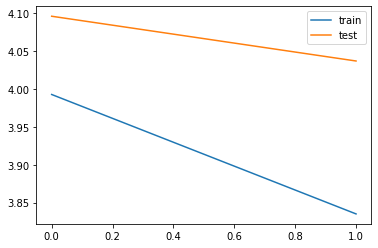

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3.5 인퍼런스 모델
- 인퍼런스 단계 : 정답 문장 없음
- 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 함
- 별도 모델 설계

### 3.5.1 정수 인덱스 -> 텍스트 데이터 준비
- 3개의 사전 정의

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 3.5.2 인코더 설계
- 인코더 모델과 디코더 모델 분리해서 설계

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더 임베딩 층
dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### 3.5.3 어텐션 매커니즘 설계
- 어텐션 매커니즘을 사용하는 출력층 설계

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 3.5.4 단어 시퀀스 완성 함수 정의

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 모델 테스트
- 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인

### 4.1 텍스트 시퀀스로 변환 함수
- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외
- Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        # 'sostoken'과 'eostoken'을 제외하고 단어를 추가합니다.
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()

### 4.2 실제 결과와 요약문 비교

In [ ]:
# for i in range(50, 100):
#     print("원문 :", seq2text(encoder_input_test[i]))
#     print("실제 요약 :", seq2summary(decoder_input_test[i]))
#     print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
#     print("\n")

In [47]:
print("원문 :", seq2text(encoder_input_test[1]))
print("실제 요약 :", seq2summary(decoder_input_test[1]))
print("예측 요약 :", decode_sequence(encoder_input_test[1].reshape(1, text_max_len)))
print("\n")

원문 : vinod kambli wife andrea accused singer ankit tiwari year old father inappropriately touching mall cctv footage surfaced shows touch footage also shows andrea altercation tiwari father andrea alleged took advantage crowd playing children 
실제 요약 : cctv footage reveals ankit tiwari dad did not touch kambli wife
예측 요약 :  ex wife wife wife wife wife on his th day




# 프로젝트 2 : 추출적 요약

### 패키지 설치

In [49]:
!pip list | grep summa

summa                         1.2.0


In [52]:
import requests
from summa.summarizer import summarize

### 데이터 불러오기

In [50]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data = data.rename(columns={'headlines': 'Summary', 'text': 'Text'})
data = data.reindex(columns=['Text', 'Summary'])
data = data['Text']
data.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: Text, dtype: object

### 요약 확인
- summa의 summarize 사용
- 첫 번째 데이터 확인
- 단어 제한 : 30

In [53]:
print(summarize(data[1], words=30))

Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


## 비교

In [60]:
from tabulate import tabulate


data1 = [
['추상적요약','낮음','적음'],
['추출적요약', '보통','보통']
]
headers = ['Summary','문법완성도','핵심단어 포함']

print(data[1])
print('추상적요약:',decode_sequence(encoder_input_test[1].reshape(1, text_max_len)))
print('추출적요약:',summarize(data[1], words=30))
print(tabulate(data1, headers=headers, tablefmt='grid'))

Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
추상적요약:  ex wife wife wife wife wife on his th day
추출적요약: Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
+------------+--------------+-----------------+
| Summary    | 문법완성도   | 핵심단어 포함   |
+============+==============+=================+
| 추상적요약 | 낮음         | 적음            |
+------------+--------------+-----------------+
| 추출적요약 | 보통         | 보통            |
+------------+--------------+-----------------+


## 회고
- 배운점 : 추상적요약과 추출적요약의 차이에 대해 알 수 있었다.
- 아쉬운점 : 모델 학습 시간이 오래걸렸다.
- 느낀점 : 어렵게만 생각했던 요약을 seq2seq과 summa로 풀 수 있는 점이 놀라웠다.
- 어려웠던 점 : 모델의 세부 인자, 파라미터에 대해 더 공부해야겠다.